In [ ]:
# 필요 라이브러리

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.ensemble import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
df = pd.read_csv('/content/Mydrive/MyDrive/data/FIFA/FIFA_train.csv')
df.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [ ]:
df.corr()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,1.000000,-0.475785,-0.423739,-0.972374,-0.630199,-0.402455,-0.544280
age,-0.475785,1.000000,0.263468,0.467345,-0.231303,0.039362,0.087319
reputation,-0.423739,0.263468,1.000000,0.521389,0.399183,0.196582,0.665982
stat_overall,-0.972374,0.467345,0.521389,1.000000,0.665453,0.400164,0.658444
stat_potential,-0.630199,-0.231303,0.399183,0.665453,1.000000,0.332578,0.611907
stat_skill_moves,-0.402455,0.039362,0.196582,0.400164,0.332578,1.000000,0.298500
value,-0.544280,0.087319,0.665982,0.658444,0.611907,0.298500,1.000000


In [ ]:
# EDA 시행 후 전반적인 데이터 양상 확인을 했고, reputation, stat_overall, stat_potentioal 과 이적료(value)간 관계성을 찾음.
# reputation 과 stat들이 value와 상관관계가 높으므로 X값으로 사용
# 이적료 예측 모델 생성을 위한 데이터 전처리
X1= df['stat_overall'].values.reshape(-1,1)
X2= df['stat_potential'].values.reshape(-1,1)
X3= df['reputation'].values.reshape(-1,1)
y = df['value'].values
columns = ['stat_overall','stat_potential','reputation']
X = np.concatenate([X1,X2,X3], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7145, 3) (1787, 3) (7145,) (1787,)


In [ ]:
scaler = StandardScaler()

# fit_transform을 통해 스케일링한 트레이닝셋,테스트셋 적용
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform( np.expand_dims(y_train, 1) ).flatten()
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform( np.expand_dims(y_test, 1) ).flatten()


print(X_test.shape, y_test.shape)


(1787, 3) (1787,)


In [ ]:
# 모델 평가를 위한 함수 생성

def regression_scores(y_true, y_pred) :
  import numpy as np
  from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
  
  MSE = mean_squared_error(y_true, y_pred)
  RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
  MAE = np.mean( np.abs((y_true - y_pred) / y_true) )
  NMAE =mean_absolute_error(y_true, y_pred)/ np.mean( np.abs(y_true) )
  MAPE = np.mean( np.abs((y_true - y_pred) / y_true) ) *100
  R2 = r2_score(y_true, y_pred)
  return {'MSE' : np.round(MSE, 3), 
          'RMSE' : np.round(RMSE, 3),
          'MAE' : np.round(MAE, 3),
          'NMAE' : np.round(NMAE, 3),
          'MAPE' : np.round(MAPE, 3),
          'R2' : np.round(R2, 3)}

In [ ]:
# 모델 평가

# linear
linear = LinearRegression()
linear.fit(X_train,y_train)
y_pred1 = linear.predict(X_test)
score1 = regression_scores(y_test, y_pred1)

# gradient boosting 
gb = GradientBoostingRegressor(random_state=1)
gb.fit(X_train, y_train)
y_pred2 = gb.predict(X_test)
score2 = regression_scores(y_test, y_pred2)


# forest
forest = RandomForestRegressor(random_state=1)
forest.fit(X_train, y_train)
y_pred3 = forest.predict(X_test)
score3 = regression_scores(y_test, y_pred3)

pd.DataFrame([score1,score2,score3], index = ['linear','gb','forest'])

# gradient boosting이 가장 효과적.

,MSE,RMSE,MAE,NMAE,MAPE,R2
linear,0.385,0.621,1.341,0.607,134.087,0.615
gb,0.048,0.219,0.425,0.153,42.488,0.952
forest,0.056,0.236,0.395,0.152,39.472,0.944


<Figure size 720x432 with 0 Axes>

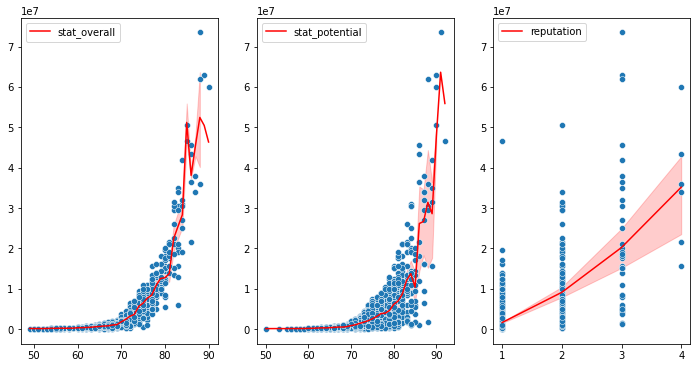

In [ ]:
# gradient boosting이 가장 적합하므로 그래프를 그려보면 아래와 같다.
plt.figure(figsize = (10,6))

gb = GradientBoostingRegressor(random_state=1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f, axes = plt.subplots(1,3,figsize=(12,6))
for i, ax in zip(range(3), axes) :
  sns.lineplot(X_test[:,i], y_pred, c = 'r', label = columns[i], ax = ax)
  sns.scatterplot(X_test[:,i], y_test, ax = ax)

plt.legend()
plt.show()

In [ ]:
test = pd.read_csv('/content/Mydrive/MyDrive/data/FIFA/FIFA_test.csv')
print(test.shape)
test.head()

(3828, 11)


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [ ]:
X1= test['stat_overall'].values.reshape(-1,1)
X2= test['stat_potential'].values.reshape(-1,1)
X3= test['reputation'].values.reshape(-1,1)
X = np.concatenate([X1,X2,X3], axis=1)
y_pred = gb.predict(X)

In [ ]:
sub = pd.read_csv('/content/Mydrive/MyDrive/data/FIFA/submission.csv')
sub.head()

,id,value
0,1,0
1,2,0
2,4,0
3,5,0
4,6,0


In [ ]:
sub['value'] = y_pred
sub.head()

,id,value
0,1,1.105282e+08
1,2,8.260770e+07
2,4,6.041560e+07
3,5,5.560226e+07
4,6,5.560226e+07


In [ ]:
sub.to_csv('submission.csv', index = False)